In [29]:
import boto3 # using AWS services
import botocore # exception management
import pandas as pd # popular library for data analysis
from IPython.display import display, Markdown # formatted output

In [30]:
# use S3 client to call most S3 APIs
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

In [31]:
# function to create a S3 bucket for our data. Catch an exception if owned by others
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

In [32]:
create_bucket('nyc-taxi-trips-analysis')

'Created or already exists nyc-taxi-trips-analysis bucket.'

In [33]:
# list bucket with matching name in my account
def list_buckets(match=''):
    response = s3.list_buckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')

In [34]:
list_buckets(match='nyc')

Existing buckets containing "nyc" string:
  nyc-ltc-result
  nyc-taxi-trips-analysis
  nyc-tlc-analysis


In [37]:
# list contents of an S3 bucket, go over paths and find those match with given string
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

In [66]:
# match with 2022 in the open dataset nyc-tlc,with size less than 250 mb
list_bucket_contents(bucket='nyc-tlc', match='2022', size_mb=250)

csv_backup/fhv_tripdata_2022-01.csv ( 69MB)
csv_backup/fhv_tripdata_2022-02.csv ( 74MB)
csv_backup/green_tripdata_2022-01.csv (  6MB)
csv_backup/green_tripdata_2022-02.csv (  7MB)
csv_backup/yellow_tripdata_2022-01.csv (239MB)
trip data/fhv_tripdata_2022-01.parquet ( 11MB)
trip data/fhv_tripdata_2022-02.parquet ( 12MB)
trip data/fhv_tripdata_2022-03.parquet ( 13MB)
trip data/fhv_tripdata_2022-04.parquet ( 12MB)
trip data/fhv_tripdata_2022-05.parquet ( 12MB)
trip data/fhv_tripdata_2022-06.parquet ( 12MB)
trip data/fhv_tripdata_2022-07.parquet ( 11MB)
trip data/fhv_tripdata_2022-08.parquet ( 11MB)
trip data/fhv_tripdata_2022-09.parquet ( 11MB)
trip data/fhv_tripdata_2022-10.parquet ( 11MB)
trip data/fhv_tripdata_2022-11.parquet ( 11MB)
trip data/fhv_tripdata_2022-12.parquet ( 12MB)
trip data/green_tripdata_2022-01.parquet (  1MB)
trip data/green_tripdata_2022-02.parquet (  1MB)
trip data/green_tripdata_2022-03.parquet (  2MB)
trip data/green_tripdata_2022-04.parquet (  1MB)
trip data/gre

In [40]:
# takes in bucket name and key (path) and rows to preview public registry data, without download or save to our own S3
def preview_csv_dataset(bucket, key, rows=10):
    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    data = pd.read_csv(url, nrows=rows)
    return data

In [42]:
df = preview_csv_dataset(bucket='nyc-tlc', key='csv_backup/yellow_tripdata_2022-01.csv', rows=100)

In [43]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5


In [44]:
df.shape

(100, 18)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               100 non-null    int64  
 1   tpep_pickup_datetime   100 non-null    object 
 2   tpep_dropoff_datetime  100 non-null    object 
 3   passenger_count        100 non-null    float64
 4   trip_distance          100 non-null    float64
 5   RatecodeID             100 non-null    float64
 6   store_and_fwd_flag     100 non-null    object 
 7   PULocationID           100 non-null    int64  
 8   DOLocationID           100 non-null    int64  
 9   payment_type           100 non-null    int64  
 10  fare_amount            100 non-null    float64
 11  extra                  100 non-null    float64
 12  mta_tax                100 non-null    float64
 13  tip_amount             100 non-null    float64
 14  tolls_amount           100 non-null    float64
 15  improve

In [46]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,1.670000,1.840000,3.854100,1.040000,163.420000,156.530000,1.370000,14.300000,1.245000,0.5,2.876000,0.458500,3.000000e-01,21.329500,2.275000
std,0.472582,1.212061,4.376173,0.196946,70.249078,79.026585,0.613896,11.403083,1.161232,0.0,3.502514,1.679632,5.021173e-16,15.238399,0.719059
min,1.000000,1.000000,0.000000,1.000000,4.000000,4.000000,1.000000,2.500000,0.000000,0.5,0.000000,0.000000,3.000000e-01,6.300000,0.000000
25%,1.000000,1.000000,1.140000,1.000000,114.000000,89.250000,1.000000,6.500000,0.500000,0.5,0.000000,0.000000,3.000000e-01,11.800000,2.500000
50%,2.000000,1.000000,2.285000,1.000000,161.000000,149.500000,1.000000,11.250000,0.500000,0.5,2.105000,0.000000,3.000000e-01,16.550000,2.500000
75%,2.000000,2.000000,4.447500,1.000000,237.000000,236.250000,2.000000,17.000000,3.000000,0.5,3.750000,0.000000,3.000000e-01,24.960000,2.500000
max,2.000000,6.000000,20.700000,2.000000,263.000000,263.000000,4.000000,52.000000,3.750000,0.5,15.750000,6.550000,3.000000e-01,78.850000,2.500000


In [47]:
# check whether the key already exist in bucket
def key_exists(bucket, key):
    try:
        s3_resource.Object(bucket, key).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The key does not exist.
            return(False)
        else:
            # Something else has gone wrong.
            raise
    else:
        # The key does exist.
        return(True)

# if key does not exist in to_bucket, copy it from the from_bucket
def copy_among_buckets(from_bucket, from_key, to_bucket, to_key):
    if not key_exists(to_bucket, to_key):
        s3_resource.meta.client.copy({'Bucket': from_bucket, 'Key': from_key}, 
                                        to_bucket, to_key)        
        print(f'File {to_key} saved to S3 bucket {to_bucket}')
    else:
        print(f'File {to_key} already exists in S3 bucket {to_bucket}') 

In [50]:
copy_among_buckets(from_bucket='nyc-tlc', from_key='csv_backup/yellow_tripdata_2022-01.csv',
                      to_bucket='nyc-taxi-trips-analysis', to_key='few-trips/yellow_tripdata_2022-01.csv')

File few-trips/yellow_tripdata_2022-01.csv saved to S3 bucket nyc-taxi-trips-analysis


In [52]:
# set up function to run S3 select. result captured in payload events
def s3_select(bucket, key, statement):
    import io

    s3_select_results = s3.select_object_content(
        Bucket=bucket,
        Key=key,
        Expression=statement,
        ExpressionType='SQL',
        InputSerialization={'CSV': {"FileHeaderInfo": "Use"}},
        OutputSerialization={'JSON': {}},
    )

    for event in s3_select_results['Payload']:
        if 'Records' in event:
            df = pd.read_json(io.StringIO(event['Records']['Payload'].decode('utf-8')), lines=True)
        elif 'Stats' in event:
            print(f"Scanned: {int(event['Stats']['Details']['BytesScanned'])/1024/1024:5.2f}MB")            
            print(f"Processed: {int(event['Stats']['Details']['BytesProcessed'])/1024/1024:5.2f}MB")
            print(f"Returned: {int(event['Stats']['Details']['BytesReturned'])/1024/1024:5.2f}MB")
    return (df)

In [59]:
df = s3_select(bucket='nyc-taxi-trips-analysis', key='few-trips/yellow_tripdata_2022-01.csv', 
          statement="""
          select passenger_count, payment_type, trip_distance, total_amount
          from s3object s 
          limit 100
          """)

Scanned:  0.25MB
Processed:  0.19MB
Returned:  0.01MB


In [60]:
df.head()

,passenger_count,payment_type,trip_distance,total_amount
0,2,1,3.80,21.95
1,1,1,2.10,13.30
2,1,1,0.97,10.56
3,1,2,1.09,11.80
4,1,1,4.30,30.30


In [62]:
# could also run on original S3 bucket 'nyc-tlc'
df = s3_select(bucket='nyc-tlc', key='csv_backup/yellow_tripdata_2022-01.csv', 
          statement="""
          select passenger_count, payment_type, trip_distance, total_amount
          from s3object s 
          limit 100
          """)

Scanned:  0.03MB
Processed:  0.02MB
Returned:  0.01MB


In [63]:
df.head()

,passenger_count,payment_type,trip_distance,total_amount
0,2,1,3.80,21.95
1,1,1,2.10,13.30
2,1,1,0.97,10.56
3,1,2,1.09,11.80
4,1,1,4.30,30.30


In [64]:
# list all files with 2022, without size limit
list_bucket_contents(bucket='nyc-tlc', match='2022')

csv_backup/fhv_tripdata_2022-01.csv ( 69MB)
csv_backup/fhv_tripdata_2022-02.csv ( 74MB)
csv_backup/fhvhv_tripdata_2022-01.csv (890MB)
csv_backup/fhvhv_tripdata_2022-02.csv (966MB)
csv_backup/green_tripdata_2022-01.csv (  6MB)
csv_backup/green_tripdata_2022-02.csv (  7MB)
csv_backup/yellow_tripdata_2022-01.csv (239MB)
csv_backup/yellow_tripdata_2022-02.csv (289MB)
trip data/fhv_tripdata_2022-01.parquet ( 11MB)
trip data/fhv_tripdata_2022-02.parquet ( 12MB)
trip data/fhv_tripdata_2022-03.parquet ( 13MB)
trip data/fhv_tripdata_2022-04.parquet ( 12MB)
trip data/fhv_tripdata_2022-05.parquet ( 12MB)
trip data/fhv_tripdata_2022-06.parquet ( 12MB)
trip data/fhv_tripdata_2022-07.parquet ( 11MB)
trip data/fhv_tripdata_2022-08.parquet ( 11MB)
trip data/fhv_tripdata_2022-09.parquet ( 11MB)
trip data/fhv_tripdata_2022-10.parquet ( 11MB)
trip data/fhv_tripdata_2022-11.parquet ( 11MB)
trip data/fhv_tripdata_2022-12.parquet ( 12MB)
trip data/fhvhv_tripdata_2022-01.parquet (357MB)
trip data/fhvhv_tripd

In [65]:
# More files, some >256 MB, can still preview but cannot use S3 select due to 256 MB limit
preview_csv_dataset(bucket='nyc-tlc', key='csv_backup/fhvhv_tripdata_2022-02.csv')

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B03404,2022-02-01 00:02:50,2022-02-01 00:13:01,17,225,NaN
1,HV0003,B03404,2022-02-01 00:20:18,2022-02-01 00:28:31,37,37,NaN
2,HV0003,B03404,2022-02-01 00:39:18,2022-02-01 00:46:54,37,37,NaN
3,HV0003,B03404,2022-02-01 00:57:01,2022-02-01 01:28:27,225,21,NaN
4,HV0003,B03404,2022-02-01 00:02:38,2022-02-01 00:14:18,25,17,NaN
5,HV0003,B03404,2022-02-01 00:27:00,2022-02-01 00:41:31,17,225,NaN
6,HV0003,B03404,2022-02-01 00:56:12,2022-02-01 01:16:19,49,79,NaN
7,HV0003,B03404,2022-02-01 00:25:58,2022-02-01 00:31:34,107,229,NaN
8,HV0005,B03406,2022-02-01 00:18:13,2022-02-01 00:25:14,75,75,NaN
9,HV0005,B03406,2022-02-01 00:30:52,2022-02-01 00:40:43,263,145,NaN


In [70]:
copy_among_buckets(from_bucket='nyc-tlc', from_key='csv_backup/fhvhv_tripdata_2022-02.csv',
                      to_bucket='nyc-taxi-trips-analysis', to_key='many-trips/fhvhv_tripdata_2022-02.csv')

File many-trips/fhvhv_tripdata_2022-02.csv already exists in S3 bucket nyc-taxi-trips-analysis


In [74]:
list_bucket_contents(bucket='nyc-taxi-trips-analysis', match='trips/fhvhv')

many-trips/fhvhv_tripdata_2022-02.csv (966MB)
Matched file size is 0.9GB with 1 files
Bucket nyc-taxi-trips-analysis total size is 1.2GB with 3 files


In [86]:
df = preview_csv_dataset(bucket='nyc-taxi-trips-analysis', key='many-trips/fhvhv_tripdata_2022-02.csv', rows=100)

In [87]:
df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B03404,2022-02-01 00:02:50,2022-02-01 00:13:01,17,225,NaN
1,HV0003,B03404,2022-02-01 00:20:18,2022-02-01 00:28:31,37,37,NaN
2,HV0003,B03404,2022-02-01 00:39:18,2022-02-01 00:46:54,37,37,NaN
3,HV0003,B03404,2022-02-01 00:57:01,2022-02-01 01:28:27,225,21,NaN
4,HV0003,B03404,2022-02-01 00:02:38,2022-02-01 00:14:18,25,17,NaN


In [88]:
df.shape

(100, 7)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hvfhs_license_num     100 non-null    object 
 1   dispatching_base_num  100 non-null    object 
 2   pickup_datetime       100 non-null    object 
 3   dropoff_datetime      100 non-null    object 
 4   PULocationID          100 non-null    int64  
 5   DOLocationID          100 non-null    int64  
 6   SR_Flag               0 non-null      float64
dtypes: float64(1), int64(2), object(4)
memory usage: 5.6+ KB


In [90]:
df.describe()

,PULocationID,DOLocationID,SR_Flag
count,100.000000,100.000000,0.0
mean,129.000000,141.370000,NaN
std,78.826366,83.332564,NaN
min,3.000000,3.000000,NaN
25%,61.500000,74.000000,NaN
50%,129.000000,145.000000,NaN
75%,189.250000,225.000000,NaN
max,263.000000,265.000000,NaN


In [ ]:
# Next: Glue (ETL service) Data Catalog

In [123]:
import numpy as np # statistical analysis
# charts and visualize
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt 
import requests
from io import StringIO
import urllib.request

In [77]:
glue = boto3.client('glue')


In [ ]:
# created Glue database using AWS console, named 'taxianalysis'

In [78]:
# get glue catalogs
def list_glue_databases():
    glue_database = glue.get_databases()

    for db in glue_database['DatabaseList']:
        print(db['Name'])

In [80]:
list_glue_databases()

default
nyc_taxi
taxianalysis


In [84]:
# then, use crawler to crawl data. Make sure to point to folder which has flat files saved inside. If point to flat
# file, when querying it might return 0 result when using AWS Athena
# 1. Create a crawler, select source folder, select target database
# 2. Run the crawler. See that 3 tables are created

In [85]:
# Transform data using AWS Athena


In [92]:
# List Glue Tables
def list_glue_tables(database, verbose=True):
    glue_tables = glue.get_tables(DatabaseName=database)
    
    for table in glue_tables['TableList']:
        display(Markdown('**Table: ' + table['Name'] + '**'))
        display(Markdown('Location: ' + table['StorageDescriptor']['Location']))
        created = table['CreatedBy'].split('/')
        display(Markdown('Created by: ' + created[-1]))
        if verbose and created[-1] == 'AWS Crawler':
            display(Markdown(f'Records: {int(table["Parameters"]["recordCount"]):,}'))
            display(Markdown(f'Average Record Size: {table["Parameters"]["averageRecordSize"]} Bytes'))
            display(Markdown(f'Dataset Size: {float(table["Parameters"]["sizeKey"])/1024/1024:3.0f} MB'))
            display(Markdown(f'Crawler: {table["Parameters"]["UPDATED_BY_CRAWLER"]}'))
        if verbose:
            df_columns = pd.DataFrame.from_dict(table["StorageDescriptor"]["Columns"])
            display(df_columns[['Name', 'Type']])
            display(Markdown('---'))

In [93]:
list_glue_tables('taxianalysis', verbose=False)

**Table: many_trips**

Location: s3://nyc-taxi-trips-analysis/many-trips/

Created by: AWS-Crawler

**Table: many_trips_well_formed**

Location: s3://nyc-taxi-trips-analysis/many-trips-well-formed/

Created by: arn:aws:iam::101951503432:root

**Table: trips_2018_01_csv**

Location: s3://nyc-taxi-trips-analysis/few-trips/trips-2018-01.csv

Created by: AWS-Crawler

**Table: yellow_tripdata_2022_01_csv**

Location: s3://nyc-taxi-trips-analysis/few-trips/yellow_tripdata_2022-01.csv

Created by: AWS-Crawler

**Table: yellow_trips_well_formed**

Location: s3://nyc-taxi-trips-analysis/yellow-trips-well-formed/

Created by: arn:aws:iam::101951503432:root

In [134]:
athena = boto3.client('athena')

In [135]:
aws_access_key_id = '#' # my AWS access key
aws_secret_access_key = '#' # my AWS secret access key
s3_client = boto3.client('s3',
                         aws_access_key_id=aws_access_key_id,
                         aws_secret_access_key=aws_secret_access_key)


In [130]:
bucket_name = 'nyc-taxi-trips-analysis'
s3_object_key = 'queries/1d936ca8-9c9d-4942-a62c-757d97815f38.csv'
# Use the S3 client to get the CSV file as a string
csv_string = s3_client.get_object(Bucket=bucket_name, Key=s3_object_key)['Body'].read().decode('utf-8')

# Use pandas to read the CSV string into a data frame
df = pd.read_csv(StringIO(csv_string))

In [140]:
# calls Athena API to execute query, save results in a bucket& folder
def athena_query(query, bucket, folder):
    output = 's3://' + bucket + '/' + folder + '/'
    response = athena.start_query_execution(QueryString=query, 
                                        ResultConfiguration={'OutputLocation': output})
    qid = response['QueryExecutionId']
    response = athena.get_query_execution(QueryExecutionId=qid)
    state = response['QueryExecution']['Status']['State']
    while state == 'RUNNING':
        response = athena.get_query_execution(QueryExecutionId=qid)
        state = response['QueryExecution']['Status']['State']
    key = folder + '/' + qid + '.csv'
    # data_source = {'Bucket': bucket, 'Key': key}
    # url = s3.generate_presigned_url(ClientMethod = 'get_object', Params = {'Bucket': bucket, 'Key': key})
    # print(url)
    print(key)
    return key

In [141]:
# query to return 1000 random samples
bucket = 'nyc-taxi-trips-analysis'
folder = 'queries'
query = 'SELECT * FROM "taxianalysis"."many_trips_well_formed" TABLESAMPLE BERNOULLI(100) LIMIT 1000;'

s3_object_key = athena_query(query, bucket, folder)


queries/c18b6bc3-e88b-441f-841e-8ceded3bafd6.csv


In [144]:
# 这个必须和上面那块分开执行，我也不知道为啥
# Use the S3 client to get the CSV file as a string
csv_string = s3_client.get_object(Bucket=bucket_name, Key=s3_object_key)['Body'].read().decode('utf-8')

# Use pandas to read the CSV string into a data frame
df = pd.read_csv(StringIO(csv_string))
df.head()

,license,dispatch,pickup_datetime,dropoff_datetime,pick_location,drop_location,flag
0,HV0003,B03404,2022-02-24 19:19:35,2022-02-24 19:37:35,85,72,NaN
1,HV0003,B03404,2022-02-24 19:40:50,2022-02-24 19:57:42,62,89,NaN
2,HV0003,B03404,2022-02-24 19:01:02,2022-02-24 19:29:10,148,1,NaN
3,HV0003,B03404,2022-02-24 19:05:31,2022-02-24 19:32:36,138,191,NaN
4,HV0003,B03404,2022-02-24 19:40:05,2022-02-24 19:58:59,19,171,NaN


In [145]:
# query to return 1000 random samples
bucket = 'nyc-taxi-trips-analysis'
folder = 'queries'
query = 'SELECT * FROM "taxianalysis"."few_trips_well_formed" TABLESAMPLE BERNOULLI(100) LIMIT 1000;'

s3_object_key = athena_query(query, bucket, folder)


queries/afa4f097-a36b-4469-8485-78d116106bad.csv


In [146]:
# 这个必须和上面那块分开执行，我也不知道为啥
# Use the S3 client to get the CSV file as a string
csv_string = s3_client.get_object(Bucket=bucket_name, Key=s3_object_key)['Body'].read().decode('utf-8')

# Use pandas to read the CSV string into a data frame
df = pd.read_csv(StringIO(csv_string))
df.head()

,vendor,rate,passengers,distance,pick_location,drop_location,payment_type,fare,extra_fare,tax,tip,toll,surcharge,congestion_fare,total_fare,pick_when,drop_when
0,2,1.0,1.0,1.05,230,143,2,7.5,1.0,0.5,0.00,0.0,0.3,2.5,11.80,2022-01-27 17:21:07,2022-01-27 17:30:33
1,2,1.0,1.0,1.84,143,246,1,8.5,1.0,0.5,3.20,0.0,0.3,2.5,16.00,2022-01-27 17:31:40,2022-01-27 17:39:59
2,2,1.0,1.0,0.66,246,90,1,5.5,1.0,0.5,2.45,0.0,0.3,2.5,12.25,2022-01-27 17:44:13,2022-01-27 17:49:38
3,2,1.0,1.0,1.54,162,50,1,15.0,1.0,0.5,3.86,0.0,0.3,2.5,23.16,2022-01-27 17:27:24,2022-01-27 17:51:59
4,2,1.0,2.0,0.45,231,125,2,4.0,1.0,0.5,0.00,0.0,0.3,2.5,8.30,2022-01-27 17:14:06,2022-01-27 17:17:30


In [147]:
# determine statistical correlation
corr = df.corr(method ='spearman')
corr

/tmp/ipykernel_20686/2760007610.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method ='spearman')


,vendor,rate,passengers,distance,pick_location,drop_location,payment_type,fare,extra_fare,tax,tip,toll,surcharge,congestion_fare,total_fare
vendor,1.000000,0.035933,0.174973,0.032460,-0.043379,-0.043212,0.007521,0.015889,-0.909165,-0.046849,0.029240,0.046327,-0.041882,-0.034224,0.022884
rate,0.035933,1.000000,0.050966,0.200093,-0.149853,-0.012869,0.021929,0.248514,0.244229,-0.089872,0.076313,0.611113,0.009281,-0.099867,0.247534
passengers,0.174973,0.050966,1.000000,0.032073,-0.035338,-0.052245,0.033371,0.033830,-0.133644,0.005578,0.006835,0.084353,-0.001376,0.049594,0.036946
distance,0.032460,0.200093,0.032073,1.000000,-0.075687,-0.049582,-0.021721,0.928494,0.062311,0.092257,0.422595,0.299247,0.075877,-0.062953,0.892140
pick_location,-0.043379,-0.149853,-0.035338,-0.075687,1.000000,0.045864,-0.010971,-0.090492,0.008188,0.008215,-0.019278,-0.132232,-0.018123,0.124765,-0.080576
drop_location,-0.043212,-0.012869,-0.052245,-0.049582,0.045864,1.000000,-0.046881,-0.060272,0.035771,-0.053615,-0.027672,-0.054905,-0.032590,0.105221,-0.047896
payment_type,0.007521,0.021929,0.033371,-0.021721,-0.010971,-0.046881,1.000000,-0.031145,-0.031368,-0.134197,-0.654798,-0.002780,-0.157169,-0.198599,-0.210351
fare,0.015889,0.248514,0.033830,0.928494,-0.090492,-0.060272,-0.031145,1.000000,0.063422,0.073544,0.453757,0.331536,0.109396,-0.055598,0.964041
extra_fare,-0.909165,0.244229,-0.133644,0.062311,0.008188,0.035771,-0.031368,0.063422,1.000000,0.149936,0.024185,0.120228,0.134227,0.141009,0.065623
tax,-0.046849,-0.089872,0.005578,0.092257,0.008215,-0.053615,-0.134197,0.073544,0.149936,1.000000,0.055122,-0.060398,0.894875,0.330442,0.073500


In [148]:
# visualize by heatmap
def heatmap(corr):
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt="3.2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

/tmp/ipykernel_20686/2967282276.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


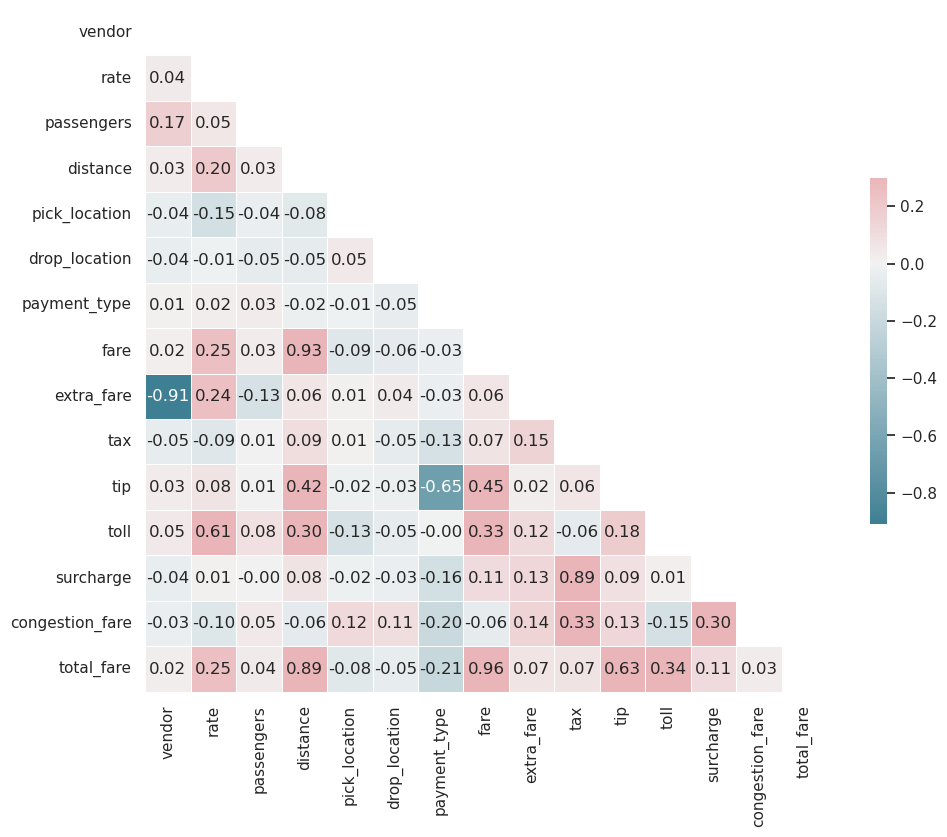

In [149]:
heatmap(corr)